In [0]:
import torch
import torchvision as vision
import cv2
import numpy as np
import torchvision.transforms as transform
import torchvision.datasets as dtst
import torch.utils as utils
import os
from matplotlib import pyplot

def initialize_dataloader(path):
    trainset_size=int(0.8*(len(os.listdir("./train/input/cv/"))))
    testset_size=len(os.listdir("./train/input/cv/"))-trainset_size
    transformation=transform.Compose([transform.Resize((256,512)) ,transform.ToTensor(),transform.Normalize(mean=(0.5,0.5,0.5),std=(0.5,0.5,0.5))])
    fulldata=dtst.ImageFolder(root=path,transform=transformation)
    trainset,testset=torch.utils.data.random_split(fulldata,[trainset_size,testset_size])

    traindataloader=utils.data.DataLoader(trainset,batch_size=10,shuffle=True,num_workers=4)
    testdataloader=utils.data.DataLoader(testset,batch_size=1,shuffle=True,num_workers=4)
    return [traindataloader,testdataloader]

input_loader,test_loader=initialize_dataloader("./train/input")


def show(retinal_image,segment,ground_truth=torch.tensor(1)):
  f = pyplot.figure(figsize=(16,16))
  retina=(retinal_image.cpu().numpy().transpose(1,2,0))
  segment=(segment.cpu().numpy().transpose(1,2,0))
  
  if(ground_truth.size()!=torch.tensor(1).size()):
    ground_truth=(ground_truth.cpu().numpy().transpose(1,2,0))
    f.add_subplot(1,3, 1)
    pyplot.imshow(np.rot90(retina,2))
    f.add_subplot(1,3, 2)
    pyplot.imshow(np.rot90(segment,2))
    f.add_subplot(1,3, 3)
    pyplot.imshow(np.rot90(ground_truth,2))
  else:
    f.add_subplot(1,2, 1)
    pyplot.imshow(np.rot90(retina,2))
    f.add_subplot(1,2, 2)
    pyplot.imshow(np.rot90(segment,2))
  pyplot.show()


In [3]:

class Conv_Block(torch.nn.Module):
  def __init__(self,input_ch,output_ch):
    super(Conv_Block,self).__init__()
    self.network=[]
    self.network+=[ torch.nn.Conv2d(input_ch,output_ch,3,1,padding=1) , torch.nn.ReLU() , \
                   torch.nn.Conv2d(output_ch,output_ch,3,1,padding=1) , torch.nn.ReLU() ]
    self.network=torch.nn.Sequential(*self.network)

  def forward(self,input):
    return self.network(input)

class DeConv_Block(torch.nn.Module):
  def __init__(self,input_ch,output_ch):
    super(DeConv_Block,self).__init__()
    self.network=[]
    self.network+= [ Conv_Block(input_ch,output_ch) ]
    self.network+= [ torch.nn.ConvTranspose2d(output_ch,output_ch,2,2) ] 
    self.network= torch.nn.Sequential(*self.network)
  def forward(self,input):
    return self.network(input)

class UNet(torch.nn.Module):
  def __init__(self):
    super(UNet,self).__init__()
    self.down_sample1=Conv_Block(3,64)
    self.down_sample2=Conv_Block(64,128)
    self.down_sample3=Conv_Block(128,256)
    self.down_sample4=Conv_Block(256,512)
   
    self.up_sample1=Conv_Block(512,512)  # 4
    
    self.up_sample2=DeConv_Block(1024,256) #3
    self.up_sample3=DeConv_Block(512,128) #2
    self.up_sample4=DeConv_Block(256,64) #1
    self.out=torch.nn.Sequential( Conv_Block(128,64) , torch.nn.Conv2d(64,3,1) )


  def forward(self,input):
    a1=self.down_sample1(input)

    a2=self.down_sample2(torch.nn.MaxPool2d(2,2)(a1))

    a3=self.down_sample3(torch.nn.MaxPool2d(2,2)(a2))

    a4=self.down_sample4(torch.nn.MaxPool2d(2,2)(a3))
    
    bootleneck=self.up_sample1(a4)
    
    b1=self.up_sample2( torch.cat([bootleneck,a4],1) )
    b2=self.up_sample3( torch.cat([a3,b1],1) )
    b3=self.up_sample4( torch.cat([a2,b2],1) )

    out=self.out( torch.cat([a1,b3],1) ) 
    return torch.functional.F.sigmoid(out)

network=UNet()

network=network.cuda()



optimizer=torch.optim.Adam(network.parameters(),lr=0.001)
loss=torch.nn.BCELoss()
history=[]
counter=0

# Load Weights
network.load_state_dict(torch.load("unet.pkl"))


<All keys matched successfully>

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1351: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


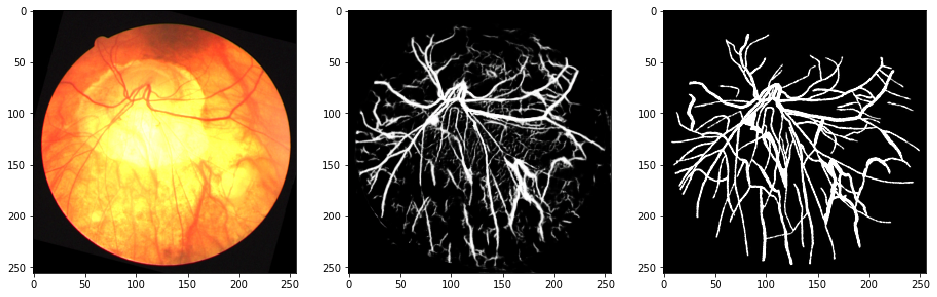

tensor(0.1030, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


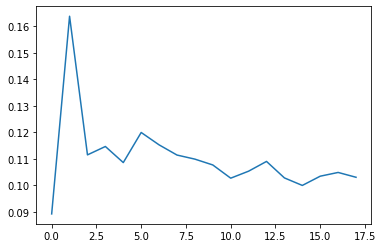

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


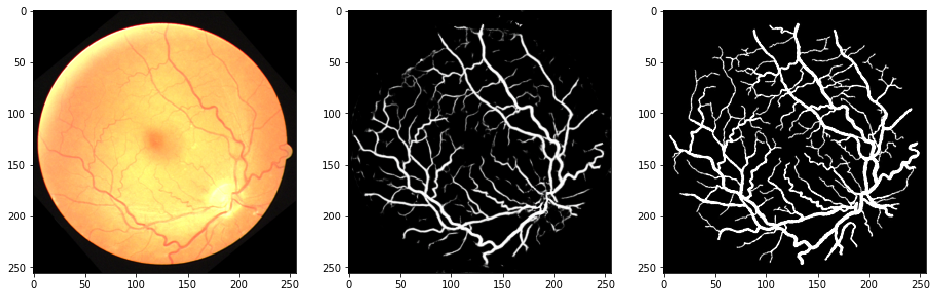

tensor(0.0904, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


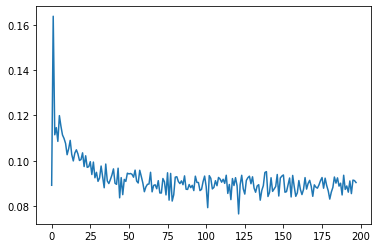

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


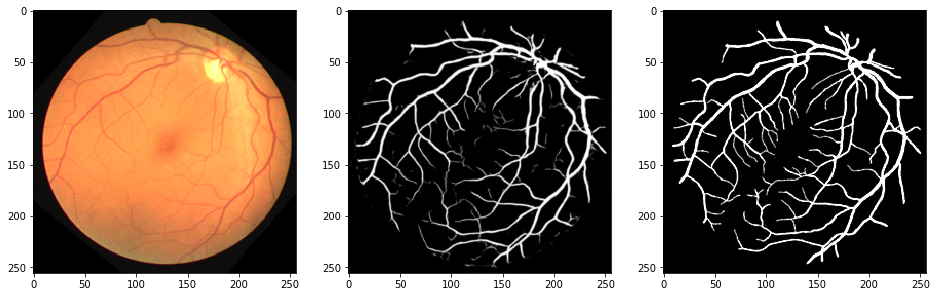

tensor(0.0884, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


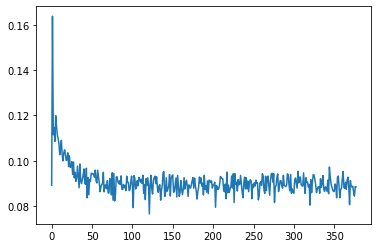

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


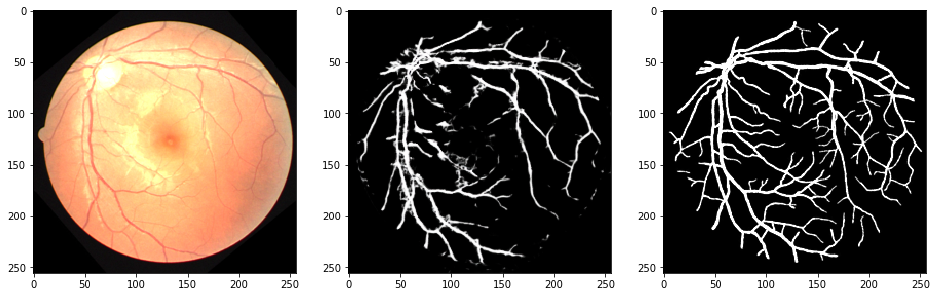

tensor(0.0887, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


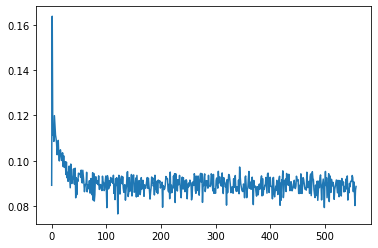

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


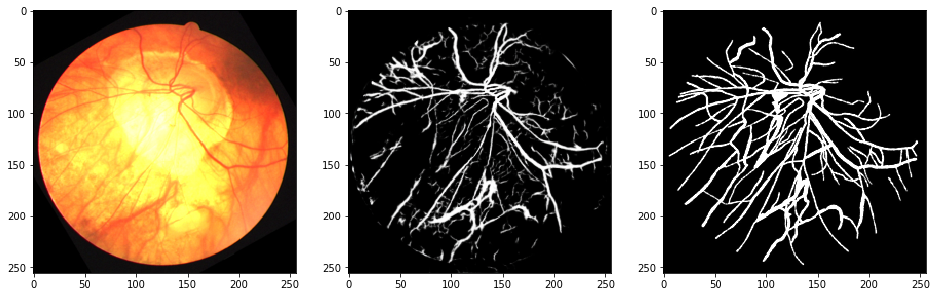

tensor(0.0851, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


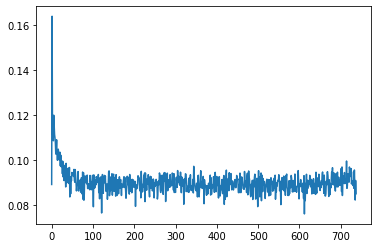

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


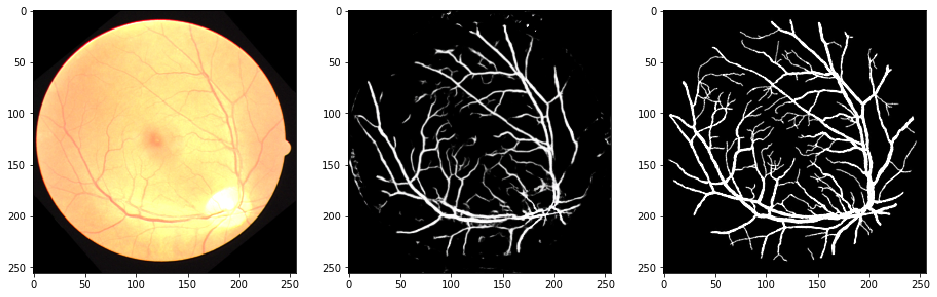

tensor(0.0901, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


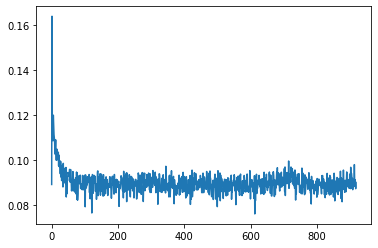

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


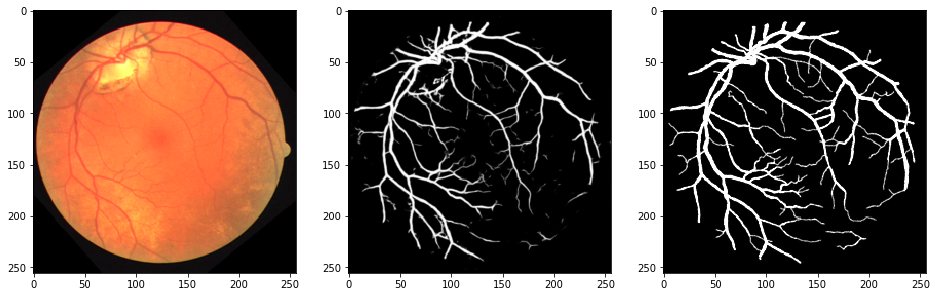

tensor(0.0890, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


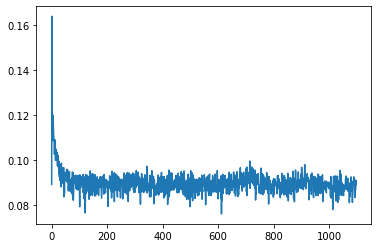

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


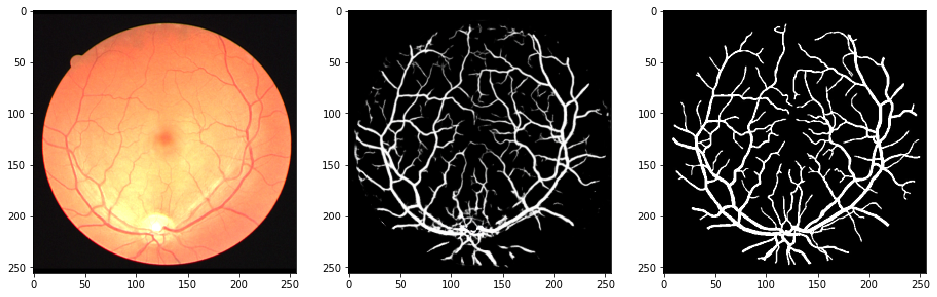

tensor(0.0875, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


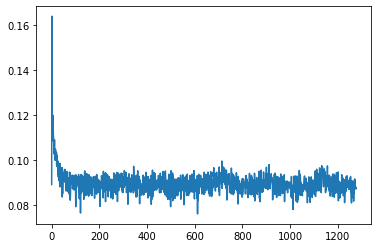

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


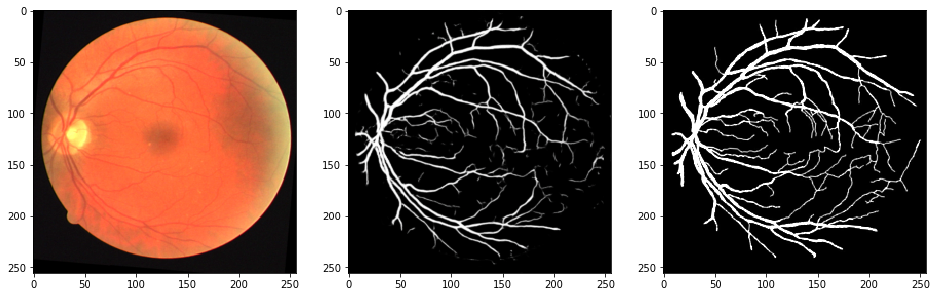

tensor(0.0845, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


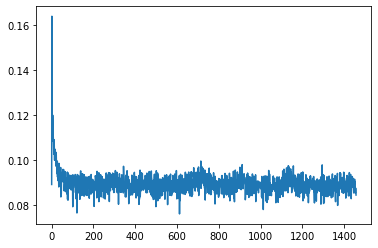

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


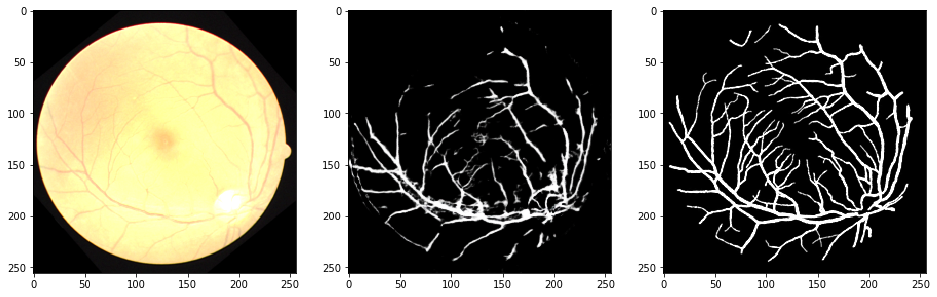

tensor(0.0874, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


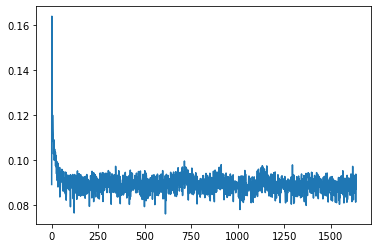

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


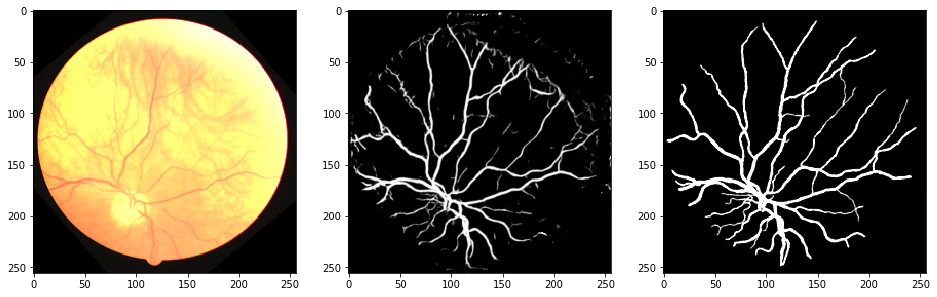

tensor(0.0877, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


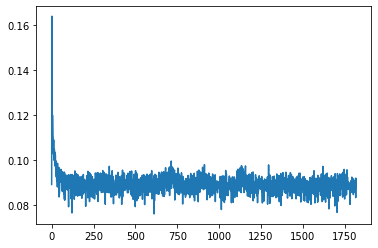

Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/lib/python3.6/multiprocessing/queues.py", line 240, in _feed
    send_bytes(obj)
  File "/usr/lib/python3.6/multiprocessing/queues.py", line 240, in _feed
    send_bytes(obj)
  File "/usr/lib/python3.6/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/usr/lib/python3.6/multiprocessing/connection.py", line 404, in _send_bytes
    self._send(header + buf)
  File "/usr/lib/python3.6/multiprocessing/connection.py", line 368, in _send
    n = write(self._handle, buf)
BrokenPipeError: [Errno 32] Broken pipe
Traceback (most recent call last):
  File "/usr/lib/python3.6/multiprocessing/queues.py", line 240, in _feed
    send_bytes(obj)
  File "/usr/lib/python3.6/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/usr/lib/python3.6/multiprocessing/connection.py", line 404, in _send_bytes
    sel

KeyboardInterrupt: ignored

In [4]:
for epoch in range(1000):
  for input,_ in input_loader:
    retina=torch.autograd.Variable( (input[:,:,:,:256]+1)/2).cuda()
    out=torch.autograd.Variable( (input[:,:,:,256:512]+1)/2 ).cuda()

    retina=retina.cuda()
    out=out.cuda()

    loss.zero_grad()
    optimizer.zero_grad()

    forward=network(retina)
    err=loss(forward,out)
    err.backward()
    optimizer.step()
    counter+=1
    history.append(err.item())
  if(epoch%10==0):
    # TestSet will displayed here
    test=next(iter(test_loader))[0]
    retina=test[0][:,:,:256].unsqueeze(0)+1
    ground_truth=test[0][:,:,256:]+1
    retina=retina.cuda()
    ground_truth=ground_truth.cuda()
    result=network(retina)[0].detach()
    show( retina[0],result,ground_truth)
    print(err)
    pyplot.plot(range(counter),history)
    pyplot.show()

In [0]:
# Save weights
# torch.save(network.state_dict(),"./unet.pkl")